# Homogeneity Score: Evaluando la Pureza de los Clusters

In [4]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler

# --- Configuración general ---
os.environ["OMP_NUM_THREADS"] = "2"  # evita warning de MKL en Windows
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("=== ANÁLISIS DE CLUSTERING: HOMOGENEIDAD, COMPLETENESS Y V-MEASURE ===\n")


=== ANÁLISIS DE CLUSTERING: HOMOGENEIDAD, COMPLETENESS Y V-MEASURE ===



In [6]:
# Crear dataset sintético
X, y_true = make_blobs(
    n_samples=300,
    centers=4,
    n_features=2,
    random_state=42,
    cluster_std=1.5
)

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Datos generados: {X.shape[0]} muestras y {X.shape[1]} características.")


Datos generados: 300 muestras y 2 características.


In [8]:
# Entrenar modelos
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_scaled)

# Calcular métricas
print("\n=== EVALUACIÓN DE MÉTRICAS DE CLUSTERING ===")

def print_metrics(y_true, y_pred, name):
    homogeneity = homogeneity_score(y_true, y_pred)
    completeness = completeness_score(y_true, y_pred)
    v_measure = v_measure_score(y_true, y_pred)
    print(f"\n{name}:")
    print(f"  Homogeneity:  {homogeneity:.3f}")
    print(f"  Completeness: {completeness:.3f}")
    print(f"  V-Measure:    {v_measure:.3f}")
    return homogeneity, completeness, v_measure

homogeneity_km, completeness_km, v_measure_km = print_metrics(y_true, y_kmeans, "K-Means")
homogeneity_db, completeness_db, v_measure_db = print_metrics(y_true, y_dbscan, "DBSCAN")



=== EVALUACIÓN DE MÉTRICAS DE CLUSTERING ===

K-Means:
  Homogeneity:  0.974
  Completeness: 0.974
  V-Measure:    0.974

DBSCAN:
  Homogeneity:  0.750
  Completeness: 1.000
  V-Measure:    0.857


In [10]:
def analyze_cluster_purity(y_true, y_pred, algorithm_name):
    """Analiza la pureza de cada cluster"""
    print(f"\n=== ANÁLISIS DE PUREZA - {algorithm_name} ===")
    
    unique_clusters = np.unique(y_pred)
    for cluster_id in unique_clusters:
        if cluster_id == -1:
            continue  # ruido en DBSCAN
        cluster_mask = y_pred == cluster_id
        cluster_classes = y_true[cluster_mask]
        unique_classes, counts = np.unique(cluster_classes, return_counts=True)
        total_samples = len(cluster_classes)
        print(f"\nCluster {cluster_id} ({total_samples} muestras):")
        for class_id, count in zip(unique_classes, counts):
            percentage = (count / total_samples) * 100
            print(f"  Clase {class_id}: {count} muestras ({percentage:.1f}%)")

analyze_cluster_purity(y_true, y_kmeans, "K-Means")
analyze_cluster_purity(y_true, y_dbscan, "DBSCAN")



=== ANÁLISIS DE PUREZA - K-Means ===

Cluster 0 (75 muestras):
  Clase 0: 74 muestras (98.7%)
  Clase 3: 1 muestras (1.3%)

Cluster 1 (75 muestras):
  Clase 2: 75 muestras (100.0%)

Cluster 2 (75 muestras):
  Clase 1: 75 muestras (100.0%)

Cluster 3 (75 muestras):
  Clase 0: 1 muestras (1.3%)
  Clase 3: 74 muestras (98.7%)

=== ANÁLISIS DE PUREZA - DBSCAN ===

Cluster 0 (150 muestras):
  Clase 0: 75 muestras (50.0%)
  Clase 3: 75 muestras (50.0%)

Cluster 1 (75 muestras):
  Clase 2: 75 muestras (100.0%)

Cluster 2 (75 muestras):
  Clase 1: 75 muestras (100.0%)


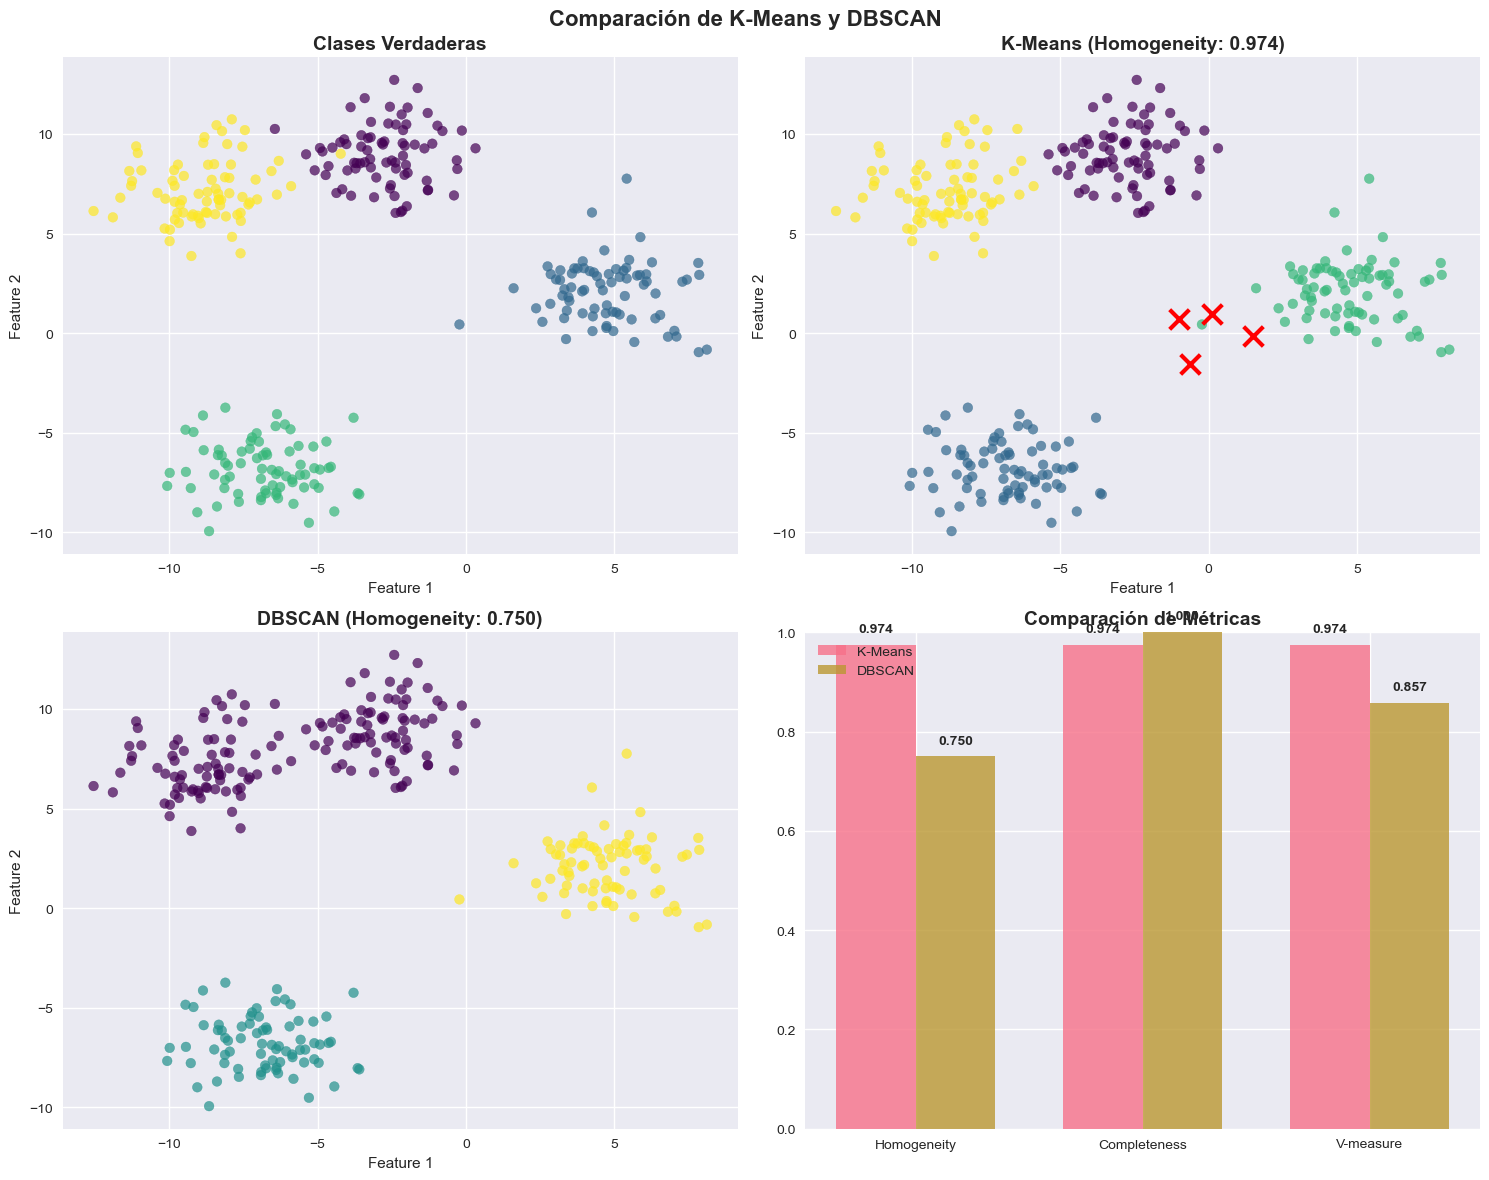

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación de K-Means y DBSCAN', fontsize=16, fontweight='bold')

# 1. Clases verdaderas
axes[0, 0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Clases Verdaderas', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')

# 2. Resultado K-Means
axes[0, 1].scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', alpha=0.7)
axes[0, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                   c='red', marker='x', s=200, linewidths=3)
axes[0, 1].set_title(f'K-Means (Homogeneity: {homogeneity_km:.3f})', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Feature 2')

# 3. Resultado DBSCAN
axes[1, 0].scatter(X[:, 0], X[:, 1], c=y_dbscan, cmap='viridis', alpha=0.7)
axes[1, 0].set_title(f'DBSCAN (Homogeneity: {homogeneity_db:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Feature 1')
axes[1, 0].set_ylabel('Feature 2')

# 4. Comparación de métricas
metrics = ['Homogeneity', 'Completeness', 'V-measure']
kmeans_scores = [homogeneity_km, completeness_km, v_measure_km]
dbscan_scores = [homogeneity_db, completeness_db, v_measure_db]
x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, kmeans_scores, width, label='K-Means', alpha=0.8)
axes[1, 1].bar(x + width/2, dbscan_scores, width, label='DBSCAN', alpha=0.8)
axes[1, 1].set_title('Comparación de Métricas', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()

for i, (km, db) in enumerate(zip(kmeans_scores, dbscan_scores)):
    axes[1, 1].text(i - width/2, km + 0.02, f'{km:.3f}', ha='center', va='bottom', fontweight='bold')
    axes[1, 1].text(i + width/2, db + 0.02, f'{db:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [14]:
def evaluate_k_range(X, y_true, k_range):
    """Evalúa homogeneidad para diferentes valores de k"""
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        y_pred = kmeans.fit_predict(X)
        score = homogeneity_score(y_true, y_pred)
        scores.append(score)
    return scores

k_range = range(2, 9)
homogeneity_scores = evaluate_k_range(X_scaled, y_true, k_range)


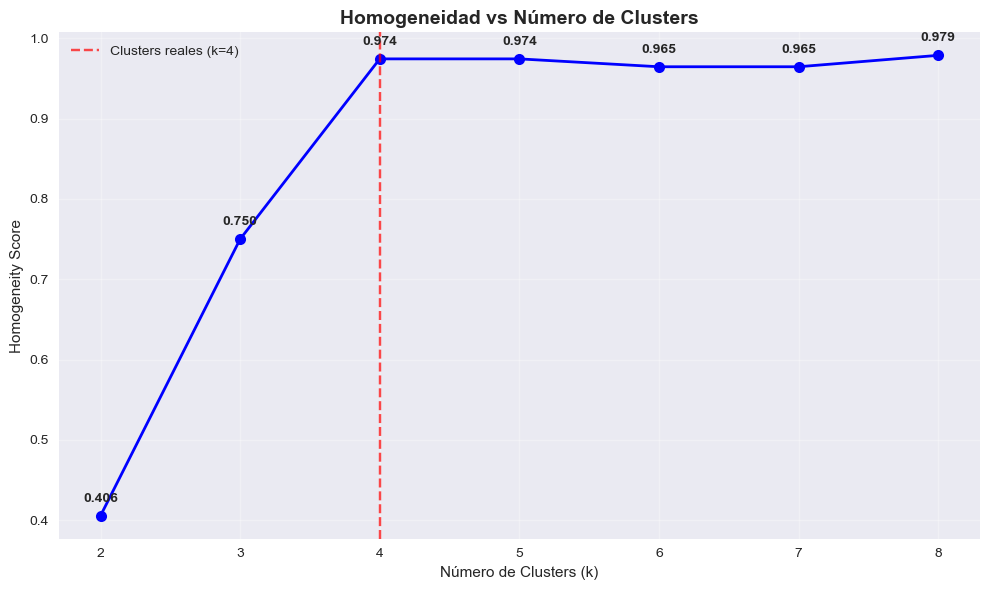

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, homogeneity_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Clusters reales (k=4)')
plt.title('Homogeneidad vs Número de Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Homogeneity Score')
plt.grid(True, alpha=0.3)
plt.legend()

for k, score in zip(k_range, homogeneity_scores):
    plt.annotate(f'{score:.3f}', (k, score), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [18]:
best_k = k_range[np.argmax(homogeneity_scores)]
best_score = max(homogeneity_scores)

print(f"\n=== INTERPRETACIÓN DE RESULTADOS ===")
print(f"Valor óptimo de homogeneidad con k={best_k}")
print(f"Score máximo obtenido: {best_score:.3f}")

if best_score >= 0.8:
    print("El modelo tiene una segmentación muy clara y bien separada.")
elif best_score >= 0.6:
    print("El modelo logra una segmentación buena con cierta mezcla entre clusters.")
else:
    print("Los clusters tienden a solaparse o estar poco definidos.")



=== INTERPRETACIÓN DE RESULTADOS ===
Valor óptimo de homogeneidad con k=8
Score máximo obtenido: 0.979
El modelo tiene una segmentación muy clara y bien separada.
